# MNIST OCR Neural Network with Varying Train/Test Splits

This notebook:

1. Loads the provided **JCB704_MNIST_resized.csv** dataset.
2. For each train/test split:
   - 5% train / 95% test
   - 10% train / 90% test
   - 20% train / 80% test
   - 40% train / 60% test
   - 80% train / 20% test
   
   it trains a neural network (MLP) with:
   - Two hidden layers of **128** and **64** nodes
   - **ReLU** activation for hidden layers
   - Sigmoid/softmax output via `MLPClassifier`
   - **Adam** optimization algorithm
   - `max_iter = 500`

3. For each split, computes performance metrics on the **test set**:
   - Precision
   - Recall
   - ROC AUC

4. Compares performance across the different train/test splits.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)


In [2]:
# Update the path if your CSV is in a different location
data_path = "JCB704_MNIST_resized.csv"

df = pd.read_csv(data_path)
print("Full dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nLabel distribution:")
print(df['labels'].value_counts())


Full dataset shape: (10842, 197)
Columns: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '15

## Helper: Train and Evaluate for a Given Train Fraction

This function:
- Takes a **train fraction** (e.g., 0.05 for 5% train / 95% test).
- Does a stratified train/test split.
- Trains the MLP classifier.
- Returns precision, recall, ROC AUC, and split sizes.

It supports both **binary** and **multi-class** labels:
- For binary classification, it uses standard precision/recall and ROC AUC on the positive class.
- For multi-class, it uses macro-averaged precision/recall and one-vs-rest ROC AUC.


In [3]:
def evaluate_train_fraction(df, train_fraction, random_state=42):
    """Train and evaluate an MLP on a given train/test split.

    train_fraction: float between 0 and 1, e.g. 0.05 for 5% train / 95% test.
    """
    assert 0 < train_fraction < 1.0, "train_fraction must be between 0 and 1."

    X = df.drop(columns=['labels']).values
    y = df['labels'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=train_fraction,
        stratify=y,
        random_state=random_state,
    )

    clf = MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',   # ReLU hidden layers
        solver='adam',      # Adam optimizer
        max_iter=500,
        random_state=random_state,
    )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)

    classes = clf.classes_
    n_classes = len(classes)

    if n_classes == 2:
        # Binary case: probabilities for the positive class
        # Assume the positive class is '1' if present, otherwise the second class
        pos_index = list(classes).index(1) if 1 in classes else 1
        y_proba_pos = y_proba[:, pos_index]

        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba_pos)
    else:
        # Multi-class: macro-averaged precision/recall and one-vs-rest ROC AUC
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')

    print(f"=== Train fraction: {train_fraction*100:.0f}% | Test fraction: {(1-train_fraction)*100:.0f}% ===")
    print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    return {
        'train_fraction': train_fraction,
        'test_fraction': 1 - train_fraction,
        'train_size': len(y_train),
        'test_size': len(y_test),
        'precision': precision,
        'recall': recall,
        'roc_auc': auc,
    }


## Run Experiments for 5/95, 10/90, 20/80, 40/60, 80/20 Splits


In [4]:
train_fractions = [0.05, 0.10, 0.20, 0.40, 0.80]

results = []
for frac in train_fractions:
    metrics = evaluate_train_fraction(df, frac)
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df['train_pct'] = results_df['train_fraction'] * 100
results_df['test_pct'] = results_df['test_fraction'] * 100
results_df = results_df[['train_pct', 'test_pct', 'train_size', 'test_size', 'precision', 'recall', 'roc_auc']]
results_df


=== Train fraction: 5% | Test fraction: 95% ===
Train size: 542, Test size: 10300
Confusion matrix:
[[4913  237]
 [ 282 4868]]

Classification report:
              precision    recall  f1-score   support

           0     0.9457    0.9540    0.9498      5150
           1     0.9536    0.9452    0.9494      5150

    accuracy                         0.9496     10300
   macro avg     0.9496    0.9496    0.9496     10300
weighted avg     0.9496    0.9496    0.9496     10300

=== Train fraction: 10% | Test fraction: 90% ===
Train size: 1084, Test size: 9758
Confusion matrix:
[[4749  130]
 [ 198 4681]]

Classification report:
              precision    recall  f1-score   support

           0     0.9600    0.9734    0.9666      4879
           1     0.9730    0.9594    0.9662      4879

    accuracy                         0.9664      9758
   macro avg     0.9665    0.9664    0.9664      9758
weighted avg     0.9665    0.9664    0.9664      9758

=== Train fraction: 20% | Test fraction: 80

,train_pct,test_pct,train_size,test_size,precision,recall,roc_auc
0,5.0,95.0,542,10300,0.953575,0.945243,0.987231
1,10.0,90.0,1084,9758,0.972979,0.959418,0.993811
2,20.0,80.0,2168,8674,0.981158,0.972562,0.997135
3,40.0,60.0,4336,6506,0.983841,0.973255,0.997773
4,80.0,20.0,8673,2169,0.995323,0.981550,0.999231


## Plot Metrics vs. Train Percentage


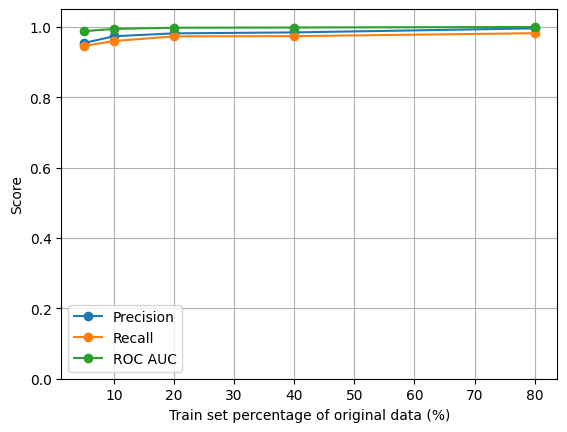

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results_df['train_pct'], results_df['precision'], marker='o', label='Precision')
plt.plot(results_df['train_pct'], results_df['recall'], marker='o', label='Recall')
plt.plot(results_df['train_pct'], results_df['roc_auc'], marker='o', label='ROC AUC')
plt.xlabel('Train set percentage of original data (%)')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.show()
